In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree, \
                           print_diro2c_rules
from baseline import print_rules, dt_feature_importance
from tasks.gaussian_quantiles import make_task
from sklearn.model_selection import train_test_split

In [2]:
clf_a, clf_b, X, y, feature_names = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

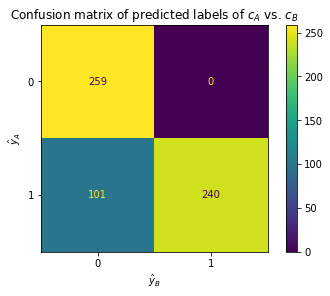

In [4]:
comparer.plot_confusion_matrix(X)

# Global explanations

In [5]:
mclass_diff = comparer.predict_mclass_diff(X)

## $(1,0)$

In [6]:
focus_class = '(1, 0)'

In [7]:
%%time
#X_sample, _ = train_test_split(X, train_size=0.1, random_state=0)
explanation = generate_diro2c_explanation(X, 0, comparer, generation_func='global',
                                          focus_class=focus_class, gn_population_size=200)
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 39.7 s, sys: 209 ms, total: 39.9 s
Wall time: 40.8 s


In [8]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [9]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']

In [10]:
tree = DecisionTreeClassifier()
tree.fit(X_explain, y_explain)
feature_names = comparer.feature_names
class_names = explanation['class_names']

In [11]:
feature_importances = dt_feature_importance(tree)
feature_order = np.flip(np.argsort(feature_importances))

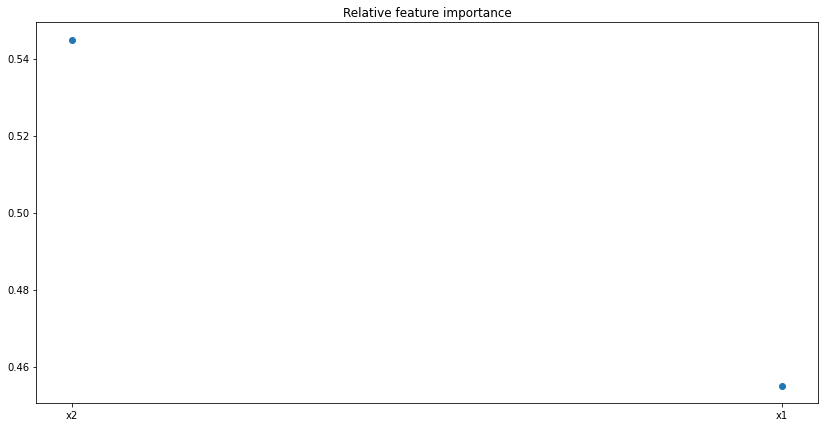

In [12]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

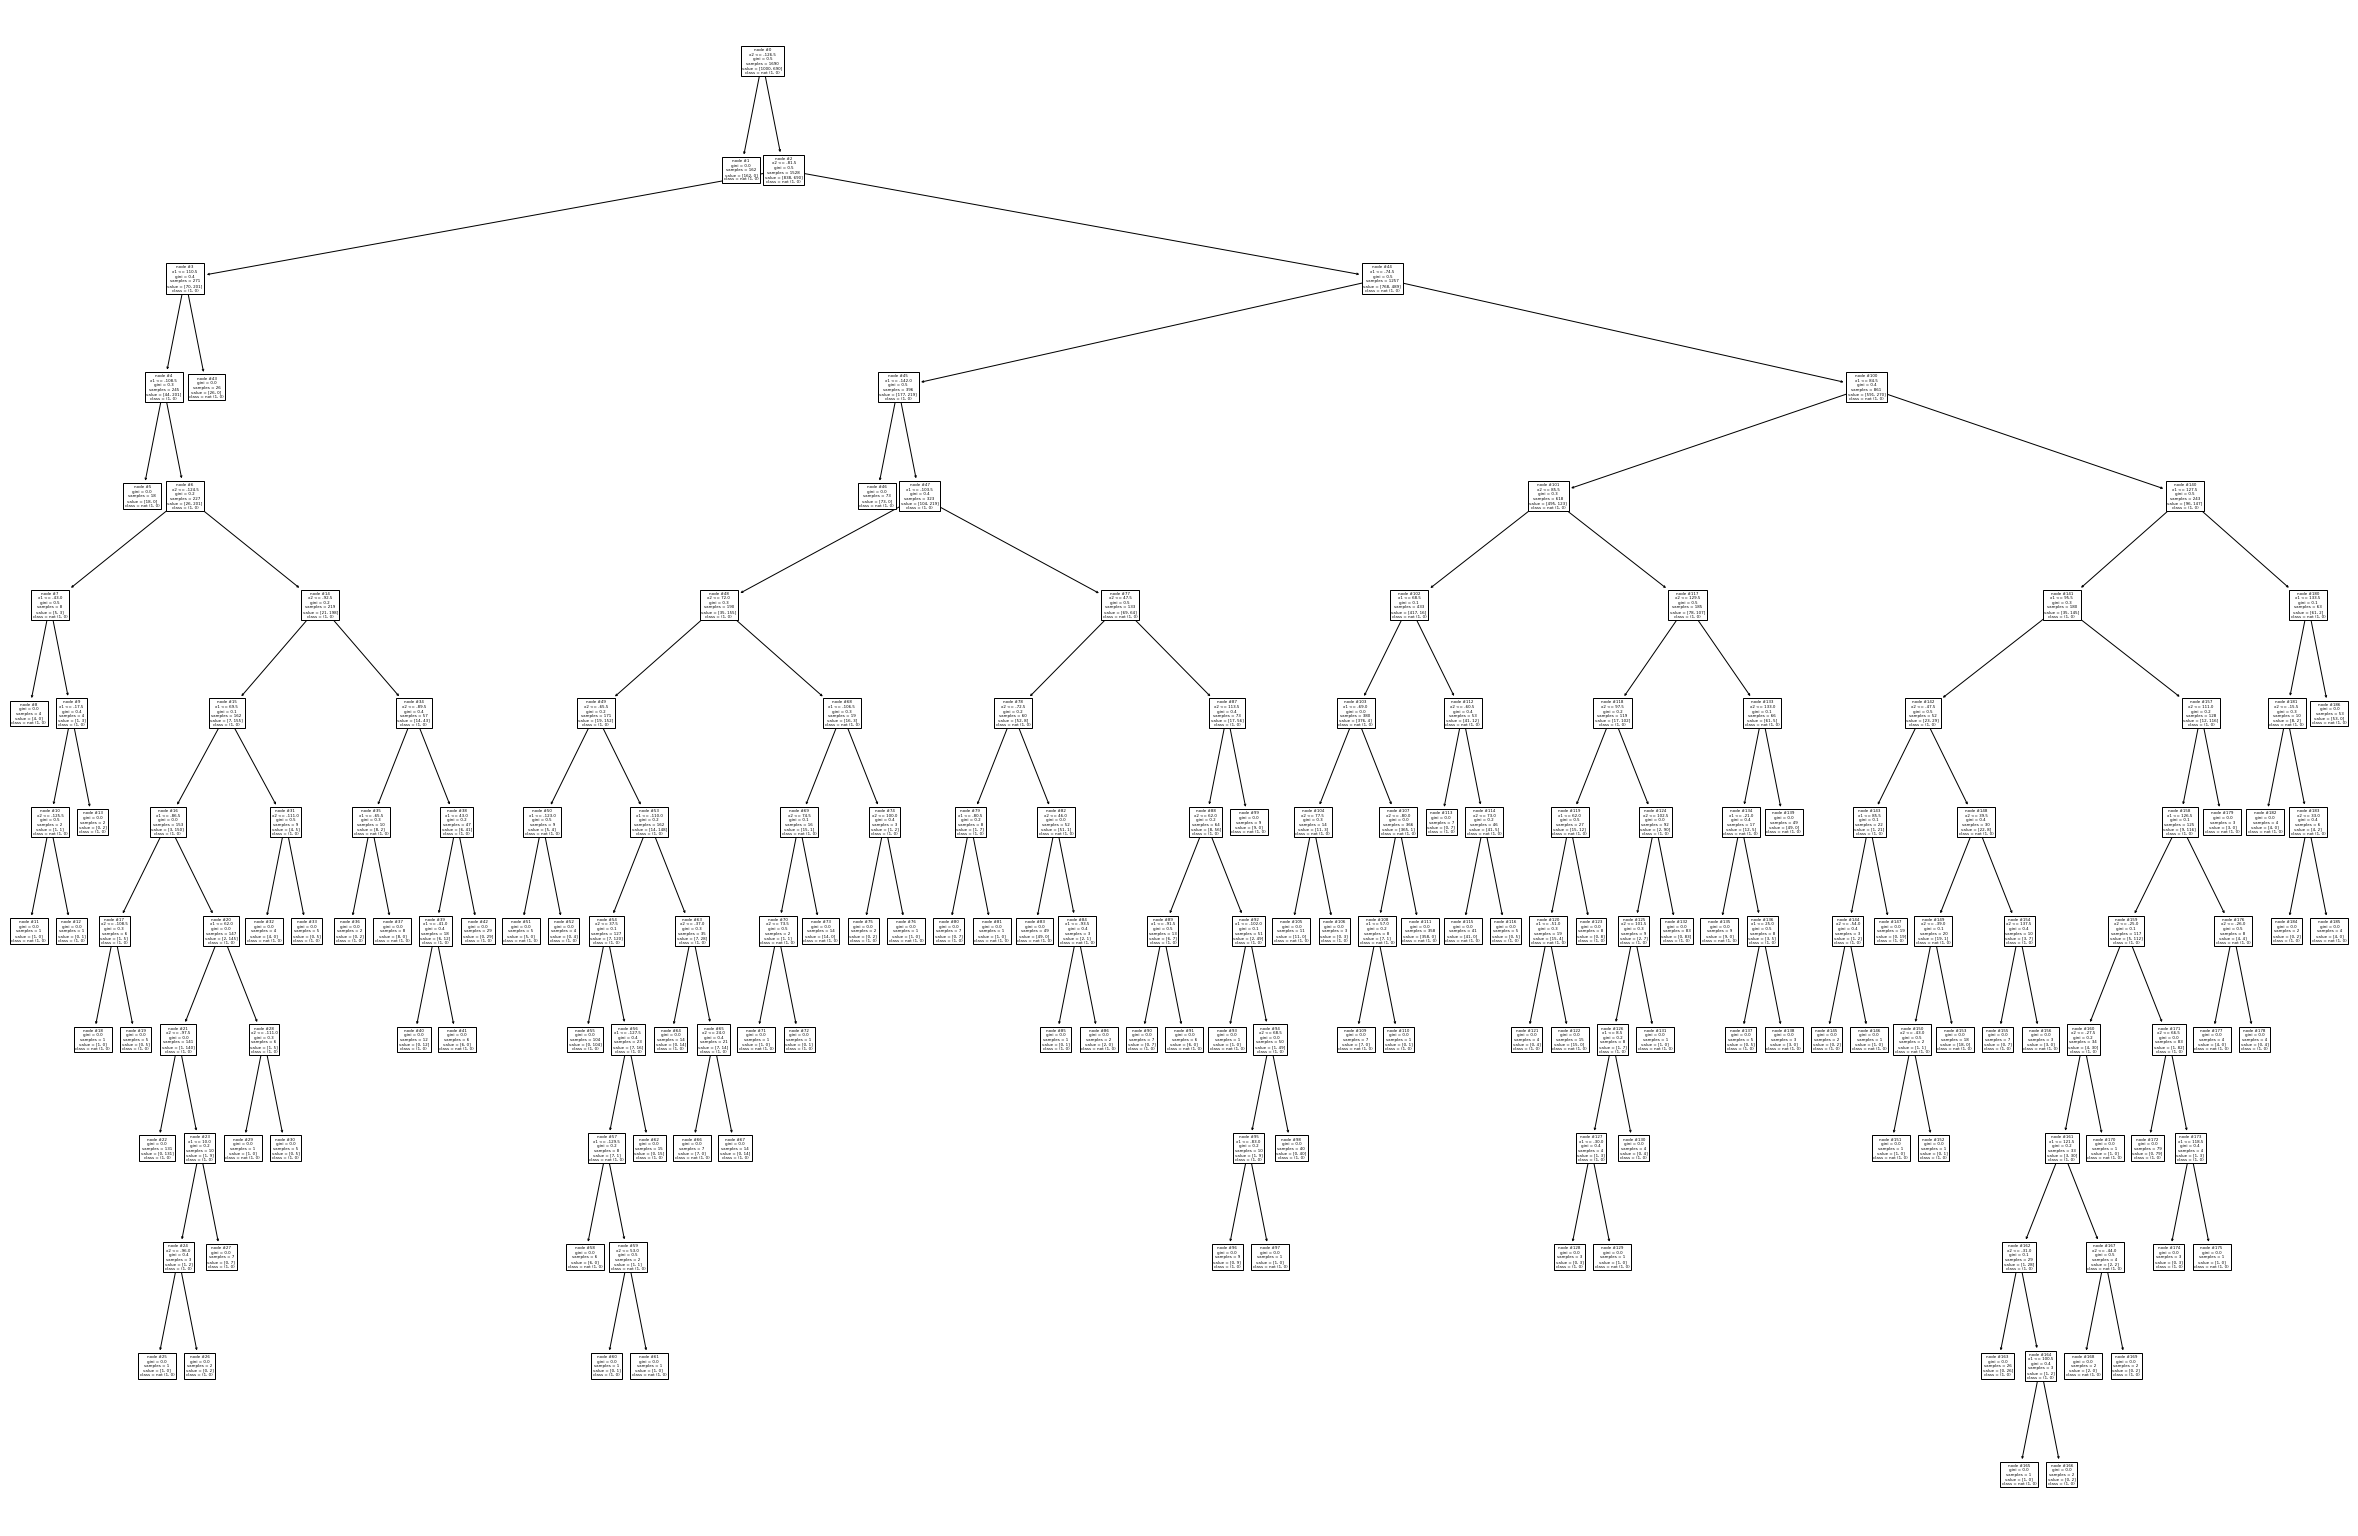

In [13]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(tree, feature_names=feature_names, class_names=class_names, ax=ax, precision=1, node_ids=True);

In [14]:
print_rules(tree, feature_names, class_names, focus_class, feature_order)

node #22: if (x2 > -124.5) and (x2 <= -97.5) and (x1 > -86.5) and (x1 <= 62.0) then class: (1, 0) (131/131 instances)
node #55: if (x2 > -65.5) and (x2 <= 37.5) and (x1 > -142.0) and (x1 <= -110.0) then class: (1, 0) (104/104 instances)
node #132: if (x2 > 102.5) and (x2 <= 129.5) and (x1 > -74.5) and (x1 <= 84.5) then class: (1, 0) (83/83 instances)
node #172: if (x2 > -25.0) and (x2 <= 66.5) and (x1 > 95.5) and (x1 <= 126.5) then class: (1, 0) (79/79 instances)
node #98: if (x2 > 68.5) and (x2 <= 113.5) and (x1 > -102.0) and (x1 <= -74.5) then class: (1, 0) (40/40 instances)
node #42: if (x2 > -89.5) and (x2 <= -81.5) and (x1 > 43.0) and (x1 <= 110.5) then class: (1, 0) (29/29 instances)
node #163: if (x2 > -81.5) and (x2 <= -31.0) and (x1 > 95.5) and (x1 <= 121.5) then class: (1, 0) (26/26 instances)
node #147: if (x2 > -81.5) and (x2 <= -47.5) and (x1 > 85.5) and (x1 <= 95.5) then class: (1, 0) (19/19 instances)
node #62: if (x2 > 37.5) and (x2 <= 72.0) and (x1 > -127.5) and (x1 <=

In [15]:
pd.Series(class_names[y_explain]).value_counts()

not (1, 0)    1000
(1, 0)         690
dtype: int64

In [17]:
indices = np.where(comparer.class_names[mclass_diff] == focus_class)[0]
pred_nodes = tree.apply(X[indices])
pd.Series(pred_nodes).value_counts()

132    17
22     15
55     12
172    12
163     7
174     6
60      2
42      2
184     2
90      2
13      2
121     2
98      1
80      1
75      1
67      1
113     1
62      1
83      1
130     1
182     1
51      1
131     1
40      1
37      1
36      1
30      1
25      1
19      1
138     1
135     1
123     1
dtype: int64

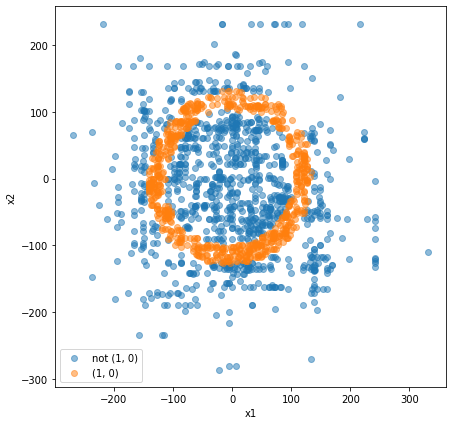

In [19]:
plot_diro2c_2d(explanation, 'x1', 'x2')